In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np
import pickle
from PIL import Image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import f1_score

In [2]:
def macro_f1_score(y_true, y_pred):
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return macro_f1

In [3]:
labelsPath = '../data/labels_pd_pickle'
file = open(labelsPath,'rb')
data = pickle.load(file)

data.drop(columns=['text_ocr'])


taskA = data.take([0,2,7],axis=1)

one_hot_encoded = pd.get_dummies(taskA['overall_sentiment'],dtype=int)
taskA['ohe'] = one_hot_encoded.values.tolist()
labels = one_hot_encoded.columns.tolist()
taskA['text_corrected'] = taskA['text_corrected'].astype('string')
codes, uniques = pd.factorize(taskA['overall_sentiment'])
taskA['class'] = codes


print(taskA['class'].value_counts())
taskAbalanced = pd.concat([
    taskA[taskA['class'] == c].sample(n=151, replace=True) for c in taskA['class'].unique()
])
print(taskAbalanced['class'].value_counts())

taskAbalanced = taskAbalanced.sample(frac=1).reset_index(drop=True)

taskAbalanced.head()


1    3127
2    2201
0    1033
3     480
4     151
Name: class, dtype: int64
4    151
3    151
2    151
1    151
0    151
Name: class, dtype: int64


,image_name,text_corrected,overall_sentiment,ohe,class
0,image_5711.jpg,I'm going camping For the rest of my fucking l...,negative,"[1, 0, 0, 0, 0]",3
1,image_4740.jpg,I M GONNA MAKE HIM A OFFER HE CAN'T REFUSE WHA...,negative,"[1, 0, 0, 0, 0]",3
2,image_58.jpg,**CALLING ALL HEROES. WE'RE BATTLING THANOS AN...,positive,"[0, 0, 1, 0, 0]",1
3,image_311.jpg,NOPE. I HAVE NOT SEEN YOUR LIPSTICK,very_positive,"[0, 0, 0, 0, 1]",0
4,image_3597.jpg,IF YOU BELIEVE HER JUST BECAUSE SHE'S A WOMAN ...,very_positive,"[0, 0, 0, 0, 1]",0


In [4]:
taskAbalanced['overall_sentiment'].unique()

array(['negative', 'positive', 'very_positive', 'neutral',
       'very_negative'], dtype=object)

In [5]:
images_folder = '../data/images/'
images = []
df = taskAbalanced
for filename in df['image_name'].values:  # Zmień 'nazwa_pliku' na nazwę kolumny z nazwami plików w DataFrame
    img = Image.open(images_folder + filename)  # Tworzenie ścieżki do pliku obrazu
    img = img.resize((224, 224))  # Dopasowanie rozmiaru obrazu, jeśli to konieczne
    img = img.convert('RGB')  # Konwertuj do formatu RGB
    img_array = np.array(img)  # Konwersja obrazu PIL na tablicę numpy
    img_array = preprocess_input(img_array)
    images.append(img_array)  # Dodanie obrazu do listy
images = np.stack(images)

In [6]:
images[:].shape

(755, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


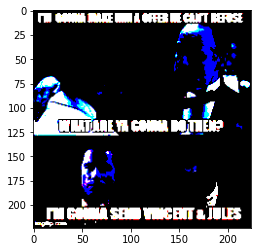

image_name                                              image_4740.jpg
text_corrected       I M GONNA MAKE HIM A OFFER HE CAN'T REFUSE WHA...
overall_sentiment                                             negative
ohe                                                    [1, 0, 0, 0, 0]
class                                                                3
Name: 1, dtype: object

In [7]:
import matplotlib.pyplot as plt
plt.imshow(images[1])
plt.show()
df.iloc[1]

In [8]:
# from sklearn.model_selection import train_test_split

# Xtrain, Xtest, ytrain, ytest = train_test_split(df['text_corrected'],df['class'],shuffle=False)
# Xtrain = np.asarray(Xtrain).astype(np.str)
# ytrain = np.asarray(ytrain).astype(np.int)
# Xtest = np.asarray(Xtest).astype(np.str)
# ytest = np.asarray(ytest).astype(np.int)

from sklearn.model_selection import KFold

kf = KFold(n_splits=5,shuffle=True, random_state=777)

trainFolds={}
testFolds={}

for i, (train_index, test_index) in enumerate(kf.split(df['text_corrected'])):
    trainFolds[i] = (df['text_corrected'][train_index].reset_index(drop=True),images[train_index], df['class'][train_index].reset_index(drop=True))
    testFolds[i]  = (df['text_corrected'][test_index].reset_index(drop=True),images[test_index] ,  df['class'][test_index].reset_index(drop=True))
    

In [9]:
def foldProccess(i,Xtrain, Xtest, ytrain, ytest, imagesTrain, imagesTest):
    
#     bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
#     bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
    
#     text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
#     preprocessed_text = bert_preprocess(text_input)
#     bertOutputs = bert_encoder(preprocessed_text)
#     l = tf.keras.layers.Dropout(0.1, name="dropout")(bertOutputs['pooled_output'])
    
    #ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    
    
    #HEAD
    #concatenated = concatenate([x, l])
    connect = Dense(512, activation='relu')(x)
    l = tf.keras.layers.Dense(5, activation='softmax', name="output")(connect)
    # Use inputs and outputs to construct a final model
    model = tf.keras.Model(inputs=[base_model.input], outputs = [l])
    METRICS = [
        tf.keras.metrics.SparseCategoricalAccuracy(),
        tf.keras.metrics.SparseCategoricalCrossentropy()
    ]
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=METRICS)
    
    
    
    history = model.fit([imagesTrain], ytrain, epochs=15,validation_split=0.1)#, callbacks=[early_stopping])
    model.save(f'models/cross4/{i}_multimod_bert_res50_e15_val0_1')
    model.evaluate([imagesTest], ytest)
    ypred = model.predict([imagesTest])
    z = np.argmax(ypred, axis=1)
    macro_f1 = macro_f1_score(ytest, z)
    print("Macro F1 Score:", macro_f1)

In [10]:
for i in range(0,5)[:]:
    Xtrain, imagesTrain, ytrain = trainFolds[i][0], trainFolds[i][1], trainFolds[i][2] 
    Xtest, imagesTest, ytest = testFolds[i][0], testFolds[i][1], testFolds[i][2]
    foldProccess(i,Xtrain,  Xtest, ytrain, ytest, imagesTrain, imagesTest)

Epoch 1/15
17/17 [==============================] - 20s 1s/step - loss: 2.4560 - sparse_categorical_accuracy: 0.2339 - sparse_categorical_crossentropy: 2.4560 - val_loss: 1.6917 - val_sparse_categorical_accuracy: 0.2787 - val_sparse_categorical_crossentropy: 1.6917
Epoch 2/15
17/17 [==============================] - 17s 994ms/step - loss: 1.4174 - sparse_categorical_accuracy: 0.4365 - sparse_categorical_crossentropy: 1.4174 - val_loss: 1.6024 - val_sparse_categorical_accuracy: 0.2459 - val_sparse_categorical_crossentropy: 1.6024
Epoch 3/15
17/17 [==============================] - 16s 975ms/step - loss: 1.0800 - sparse_categorical_accuracy: 0.5838 - sparse_categorical_crossentropy: 1.0800 - val_loss: 1.6737 - val_sparse_categorical_accuracy: 0.3607 - val_sparse_categorical_crossentropy: 1.6737
Epoch 4/15
17/17 [==============================] - 18s 1s/step - loss: 0.7250 - sparse_categorical_accuracy: 0.7882 - sparse_categorical_crossentropy: 0.7250 - val_loss: 1.7383 - val_sparse_categ

/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


5/5 [==============================] - 5s 949ms/step - loss: 3.3386 - sparse_categorical_accuracy: 0.3377 - sparse_categorical_crossentropy: 3.3386
Macro F1 Score: 0.3521854665887395
Epoch 1/15
17/17 [==============================] - 21s 1s/step - loss: 2.5941 - sparse_categorical_accuracy: 0.2155 - sparse_categorical_crossentropy: 2.5941 - val_loss: 1.6211 - val_sparse_categorical_accuracy: 0.2623 - val_sparse_categorical_crossentropy: 1.6211
Epoch 2/15
17/17 [==============================] - 15s 896ms/step - loss: 1.5512 - sparse_categorical_accuracy: 0.3315 - sparse_categorical_crossentropy: 1.5512 - val_loss: 1.6300 - val_sparse_categorical_accuracy: 0.2787 - val_sparse_categorical_crossentropy: 1.6300
Epoch 3/15
17/17 [==============================] - 15s 906ms/step - loss: 1.3149 - sparse_categorical_accuracy: 0.4715 - sparse_categorical_crossentropy: 1.3149 - val_loss: 1.7015 - val_sparse_categorical_accuracy: 0.2131 - val_sparse_categorical_crossentropy: 1.7015
Epoch 4/15
17

/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


5/5 [==============================] - 4s 778ms/step - loss: 3.2367 - sparse_categorical_accuracy: 0.3642 - sparse_categorical_crossentropy: 3.2367
Macro F1 Score: 0.36675516990729856
Epoch 1/15
17/17 [==============================] - 18s 940ms/step - loss: 2.3471 - sparse_categorical_accuracy: 0.2339 - sparse_categorical_crossentropy: 2.3471 - val_loss: 1.6258 - val_sparse_categorical_accuracy: 0.2623 - val_sparse_categorical_crossentropy: 1.6258
Epoch 2/15
17/17 [==============================] - 16s 922ms/step - loss: 1.3698 - sparse_categorical_accuracy: 0.4475 - sparse_categorical_crossentropy: 1.3698 - val_loss: 1.5611 - val_sparse_categorical_accuracy: 0.2787 - val_sparse_categorical_crossentropy: 1.5611
Epoch 3/15
17/17 [==============================] - 15s 912ms/step - loss: 1.0798 - sparse_categorical_accuracy: 0.5985 - sparse_categorical_crossentropy: 1.0798 - val_loss: 1.7016 - val_sparse_categorical_accuracy: 0.2951 - val_sparse_categorical_crossentropy: 1.7016
Epoch 4/1

/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


5/5 [==============================] - 4s 768ms/step - loss: 3.4659 - sparse_categorical_accuracy: 0.3311 - sparse_categorical_crossentropy: 3.4659
Macro F1 Score: 0.3107388764666692
Epoch 1/15
17/17 [==============================] - 17s 949ms/step - loss: 2.3880 - sparse_categorical_accuracy: 0.2063 - sparse_categorical_crossentropy: 2.3880 - val_loss: 1.7610 - val_sparse_categorical_accuracy: 0.2131 - val_sparse_categorical_crossentropy: 1.7610
Epoch 2/15
17/17 [==============================] - 15s 918ms/step - loss: 1.4852 - sparse_categorical_accuracy: 0.3517 - sparse_categorical_crossentropy: 1.4852 - val_loss: 1.7127 - val_sparse_categorical_accuracy: 0.1803 - val_sparse_categorical_crossentropy: 1.7127
Epoch 3/15
17/17 [==============================] - 15s 911ms/step - loss: 1.2027 - sparse_categorical_accuracy: 0.5304 - sparse_categorical_crossentropy: 1.2027 - val_loss: 1.9059 - val_sparse_categorical_accuracy: 0.2787 - val_sparse_categorical_crossentropy: 1.9059
Epoch 4/15

/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


5/5 [==============================] - 4s 770ms/step - loss: 3.5439 - sparse_categorical_accuracy: 0.3709 - sparse_categorical_crossentropy: 3.5439
Macro F1 Score: 0.3584505331200427
Epoch 1/15
17/17 [==============================] - 18s 976ms/step - loss: 2.6110 - sparse_categorical_accuracy: 0.2044 - sparse_categorical_crossentropy: 2.6110 - val_loss: 1.6981 - val_sparse_categorical_accuracy: 0.1967 - val_sparse_categorical_crossentropy: 1.6981
Epoch 2/15
17/17 [==============================] - 16s 919ms/step - loss: 1.4209 - sparse_categorical_accuracy: 0.3775 - sparse_categorical_crossentropy: 1.4209 - val_loss: 1.6081 - val_sparse_categorical_accuracy: 0.3115 - val_sparse_categorical_crossentropy: 1.6081
Epoch 3/15
17/17 [==============================] - 15s 917ms/step - loss: 1.0994 - sparse_categorical_accuracy: 0.5893 - sparse_categorical_crossentropy: 1.0994 - val_loss: 1.6388 - val_sparse_categorical_accuracy: 0.2623 - val_sparse_categorical_crossentropy: 1.6388
Epoch 4/15

/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


5/5 [==============================] - 4s 810ms/step - loss: 3.5390 - sparse_categorical_accuracy: 0.3444 - sparse_categorical_crossentropy: 3.5390
Macro F1 Score: 0.3514266195729589


In [ ]:
model.save('models/multimod_bert_res50_v7_e18_val0_1')

In [ ]:
model.evaluate([Xtest, images[566:]], ytest)

In [ ]:
ypred = model.predict([Xtest, images[566:]])
z = np.argmax(ypred, axis=1)

In [ ]:
macro_f1 = macro_f1_score(ytest, z)
print("Macro F1 Score:", macro_f1)

In [ ]:
history.history

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Wyświetlenie wartości straty dla zbioru treningowego i walidacyjnego
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
    plt.plot(history.history['sparse_categorical_crossentropy'], label='sparse_categorical_crossentropy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    plt.show()
    
    # Wyświetlenie wartości dokładności dla zbioru treningowego i walidacyjnego
    #plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['val_sparse_categorical_crossentropy'], label='val_sparse_categorical_crossentropy')
    plt.xlabel('Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.legend()
    plt.show()
plot_history(history)